In [1]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

from skimage.transform import resize
from skimage import io, transform, util
from scipy.signal import argrelextrema
from sklearn.metrics import pairwise_distances
from operator import itemgetter
from skimage.filters import threshold_mean

from keras.models import load_model
import h5py

# from skgof import ks_test, cvm_test, ad_test
from scipy.stats import ks_2samp, anderson_ksamp

c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\jhelu\miniconda3\envs\cs682\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [3]:
from process_segmentation_data import *
transformed_dataset = SegmentaionDataset('./datasets/train_data_icdar2019/strings/',
                                           transform=transforms.Compose([ToTensor()]))

In [4]:
len(transformed_dataset)

21876

In [5]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmark'].size(), sample['values'])

    if i == 3:
        break

0 torch.Size([1, 33, 700]) torch.Size([1, 1, 700]) 10508
1 torch.Size([1, 33, 700]) torch.Size([1, 1, 700]) 20690
2 torch.Size([1, 33, 700]) torch.Size([1, 1, 700]) 7526
3 torch.Size([1, 33, 700]) torch.Size([1, 1, 700]) 17687


In [5]:
batch_size_train = 64
batch_size_test = 1000
NUM_TRAIN = int(0.8 * len(transformed_dataset))
NUM_VAL = int(0.9 * len(transformed_dataset))
NUM_TEST = len(transformed_dataset)

loader_train = DataLoader(transformed_dataset, batch_size=batch_size_train,
                                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size_train, 
                                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_VAL)))

loader_test = DataLoader(transformed_dataset,batch_size = NUM_TEST - NUM_VAL,
                                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL, NUM_TEST)))

In [6]:
# for i_batch, sample_batched in enumerate(loader_val):
#     print(i_batch, sample_batched['image'].size(),sample_batched['landmark'].size())
for i_batch, sample_batched in enumerate(loader_test):
    print(i_batch, sample_batched['image'].size(),sample_batched['landmark'].size())

0 torch.Size([2188, 1, 33, 700]) torch.Size([2188, 1, 1, 700])


In [10]:
def my_custom_euclidean(x, y):
    return torch.mean(torch.sqrt(torch.sum(torch.square(x-y), dim=-1)))

class CustomActivation_inverse_quadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_quadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/(1 + (self.epsilon*x)**2)
    
def check_accuracy_part34(loader, model):   
    num_correct = 0
    num_samples = 0
    total_loss = []
#     orig_ks_loss = [[], []]
#     ks_loss = [[], []]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, x_y in enumerate(loader):
            x = x_y['image']
            y = x_y['landmark']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
#             loss = torch.dist(scores, y)
#             total_loss.append(loss.item())

#             loss = my_custom_euclidean(scores,y)
            loss = F.mse_loss(scores,y)
            total_loss.append(float(loss))
#             scores_numpy = scores.detach().cpu().numpy()
#             scores_numpy = scores_numpy.reshape((scores_numpy.shape[0], -1))
#             y_numpy = y.detach().cpu().numpy()
#             y_numpy = y_numpy.reshape((y_numpy.shape[0], -1))
#             for i in range(len(scores_numpy)):
#                 index_max = argrelextrema(scores_numpy[i], np.greater)[0]
#                 score_proj  = np.zeros(y_numpy[i].shape)
#                 score_proj[index_max] = 1
#                 stat, pvalue = ks_2samp(score_proj, y_numpy[i])
#                 ks_loss[0].append(stat)
#                 ks_loss[1].append(pvalue)
#                 stat, pvalue = ks_2samp(scores_numpy[i], y_numpy[i])
#                 orig_ks_loss[0].append(stat)
#                 orig_ks_loss[1].append(pvalue)
    print('train/val loss = %.4f' % (np.mean(np.asarray(total_loss))))
#     print('ks_test (stat pvalue) = %.4f, %.4f' %(np.mean(ks_loss[0]), np.mean(ks_loss[1])))
#     print('orig ks_test (stat pvalue) = %.4f, %.4f' %(np.mean(orig_ks_loss[0]), np.mean(orig_ks_loss[1])))
#     return np.mean(np.asarray(total_loss)), np.mean(ks_loss[0]), np.mean(ks_loss[1])
    return np.mean(np.asarray(total_loss))
        
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_loss, train_ks1, train_ks2, val_loss, val_ks1, val_ks2 = [], [], [], [], [], []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, x_y in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x_y['image']
            y = x_y['landmark']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            #print(scores.size())
            #loss = F.cross_entropy(scores, y)
#             loss = torch.dist(scores, y)

#             loss = my_custom_euclidean(scores,y)
            loss = F.mse_loss(scores,y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, train loss = %.4f' % (t, loss.item()))
                print()
            if t == 0:
                print("epoch ", e)
                l = check_accuracy_part34(loader_train, model)
                train_loss.append(l)
#                 train_ks1.append(ks1)
#                 train_ks2.append(ks2)
                print()
                l = check_accuracy_part34(loader_val, model)
                val_loss.append(l)
#                 val_ks1.append(ks1)
#                 val_ks2.append(ks2)
                print()
#                 print('Iteration %d, train loss = %.4f' % (t, val_loss.item()))

        l = check_accuracy_part34(loader_val, model)
#         val_loss.append(l)
#         val_ks1.append(ks1)
#         val_ks2.append(ks2)
#         print()
        scheduler.step(l)
                
    return train_loss, train_ks1, train_ks2, val_loss, val_ks1, val_ks2
                
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [6]:
filters = [[5,5], [5,5], [3,7], [5,5], [3,3], [5,5], [5,2], [5, 5], [5,3], [3,3]]
stride = [[2,1], [1,2], [1,1], [1,1], [1,1], [1,2], [1,1], [1,2], [1,1], [1,1]]
padding = [[0,0], [0,2], [0,3], [0,2], [0,1], [0,2], [0,0], [0,1], [0,1], [0,0]]

filters = [[5,5], [5,5], [3,7], [5,5], [3,3], [5,5], [5,2], [5, 5], [5,3], [3,3]]
stride = [[1,1], [1,2], [1,1], [1,1], [1,1], [1,2], [1,1], [1,2], [1,1], [1,1]]
padding = [[2,0], [2,2], [1,3], [2,2], [1,1], [2,2], [2,0], [2,1], [2,1], [1,0]]

filters = np.asarray(filters)
padding = np.asarray(padding)
stride = np.asarray(stride)

filters_copy = filters.copy()
padding_copy = padding.copy()
stride_copy = stride.copy()

filters[:, 0] = filters_copy[:, 1]
filters[:, 1] = filters_copy[:, 0]
padding[:, 0] = padding_copy[:, 1]
padding[:, 1] = padding_copy[:, 0]
stride[:, 0] = stride_copy[:, 1]
stride[:, 1] = stride_copy[:, 0]

In [7]:

input = [33, 700]
for i in range(len(filters)):
    input[0] = (input[0]+2*padding[i][0]-filters[i][0])/stride[i][0]+1
    input[1] = (input[1]+2*padding[i][1]-filters[i][1])/stride[i][1]+1
input

[1.0, 700.0]

In [31]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
class CustomActivation(nn.Module):
    def __init__(self, mean=0, std=1, _min=0.0, _max=1.0):
        super(CustomActivation, self).__init__()
        self.mean = mean
        self.std = std
        self.min = _min
        self.max = _max
        
    def forward(self, x):
        gauss = torch.exp((-(x - self.mean)**2)/(2*self.std**2))
        return torch.clamp(gauss, min=self.min, max=self.max)
    
class CustomActivation_inverse_quadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_quadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/(1 + (self.epsilon*x)**2)
    
class CustomActivation_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return torch.sqrt(1 + (self.epsilon*x)**2)
    
class CustomActivation_inverse_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/torch.sqrt(1 + (self.epsilon*x)**2)
    
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=tuple(filters[0]), padding=tuple(padding[0]), stride= tuple(stride[0]), bias = True), #26x26 , stride=(2,1)
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[1]), padding=tuple(padding[1]), stride=tuple(stride[1]), bias = True), #26x26
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[2]), padding=tuple(padding[2]), stride=tuple(stride[2]), bias = True), #13x13
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[3]), padding=tuple(padding[3]), stride=tuple(stride[3]), bias = True), #13x13
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[4]), padding=tuple(padding[4]), stride=tuple(stride[4]), bias = True), #13x13
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[5]), padding=tuple(padding[5]), stride=tuple(stride[5]), bias = True), #7x7
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[6]), padding=tuple(padding[6]), stride=tuple(stride[6]), bias = True), #7x7
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[7]), padding=tuple(padding[7]), stride=tuple(stride[7]), bias = True), #7x7
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=tuple(filters[8]), padding=tuple(padding[8]), stride=tuple(stride[8]), bias = True), #7x7
    nn.BatchNorm2d(6),
#     nn.Tanh(),
    nn.ReLU(),
    nn.Conv2d(6, 1, kernel_size=tuple(filters[9]), padding=tuple(padding[9]), stride=tuple(stride[9]), bias = True), #7x7
#     nn.ReLU(),
#     nn.Sigmoid(),
#     nn.BatchNorm2d(1),
#     CustomActivation(),
#     CustomActivation_inverse_multiquadratic(),
#     nn.ReLU()()
    CustomActivation_inverse_quadratic()
)

# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold = 1e-2, patience=3, verbose=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 5)

train_loss, train_ks1, train_ks2, val_loss, val_ks1, val_ks2 = train_part34(model, optimizer, epochs=10)

Iteration 0, train loss = 0.8595

epoch  0
train/val loss = 0.9454

train/val loss = 0.9454

Iteration 100, train loss = 0.0511

Iteration 200, train loss = 0.0422

train/val loss = 0.0413
Iteration 0, train loss = 0.0403

epoch  1
train/val loss = 0.0412

train/val loss = 0.0414

Iteration 100, train loss = 0.0387

Iteration 200, train loss = 0.0360

train/val loss = 0.0380
Iteration 0, train loss = 0.0368

epoch  2
train/val loss = 0.0377

train/val loss = 0.0382

Iteration 100, train loss = 0.0384

Iteration 200, train loss = 0.0357

train/val loss = 0.0370
Iteration 0, train loss = 0.0389

epoch  3
train/val loss = 0.0367

train/val loss = 0.0370

Iteration 100, train loss = 0.0357

Iteration 200, train loss = 0.0370

train/val loss = 0.0364
Iteration 0, train loss = 0.0368

epoch  4
train/val loss = 0.0361

train/val loss = 0.0364

Iteration 100, train loss = 0.0378

Iteration 200, train loss = 0.0358

train/val loss = 0.0362
Iteration 0, train loss = 0.0359

epoch  5
train/val lo

In [32]:
torch.save(model, "segmenter/segmenter_inverse_quadratic_mse_relu_700.h5")
# model = torch.load("segmenter/segmenter_gaussian_mse_relu_700.h5")
# model.eval()
test_loss = check_accuracy_part34(loader_test, model)
# train_loss_list = [0.9328, 0.0532, 0.0387, 0.0367, 0.0360, 0.0356, 0.0353, 0.0351, 0.0349, 0.0348]
# val_loss_list = [0.9323, 0.0534, 0.0377, 0.0368, 0.0360,  0.0356, 0.0356, 0.0352, 0.0350, 0.0350]

train/val loss = 0.0346


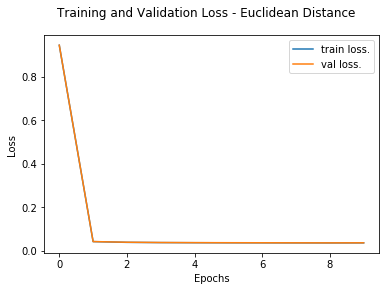

In [33]:
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, label='train loss.')
plt.plot(np.arange(len(val_loss)), val_loss, label='val loss.')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.suptitle('Training and Validation Loss - Euclidean Distance')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(np.arange(len(train_ks2)), train_ks1, c='r', label='train acc.')
plt.plot(np.arange(len(val_ks2)), val_ks1, c='b', label='val acc.')
plt.xticks([1,2,3,4,5])
plt.ylabel('ks_test - statistic')
plt.xlabel('Epochs')
plt.suptitle('KS_test on training and validation set')
plt.legend()
plt.show()

In [34]:
stat_plot = {}
stat_plot['train_loss'] = train_loss
stat_plot['val_loss'] = val_loss
stat_plot['test_loss'] = test_loss
with open('seg-plot/stat_plot_inverse_quadratic_700_mse_relu.json', 'w') as fp:
    json.dump(stat_plot, fp)

Relu 0.0345735102891922
Sigmoid 0.03459661826491356
Gaussian 0.034294724464416504
Inv. quadratic 0.034570541232824326
Inv. multiquadratic 0.03710968792438507


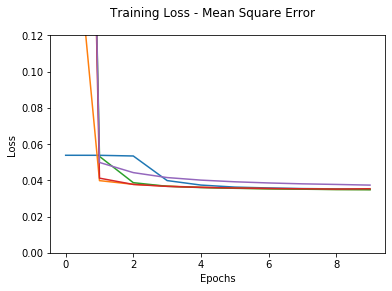

In [53]:
# names = ['stat_plot_inverse_multiquadratic_700', 'stat_plot_sigmoid_700', 'stat_plot_gaussian_700']
# labels = ['inv. multiquadratic', 'sigmoid', 'gaussian']
names = ['stat_plot_relu_700_mse_relu', 'stat_plot_sigmoid_700_mse_relu',
          'stat_plot_gaussian_700_mse_relu',
           'stat_plot_inverse_quadratic_700_mse_relu', 'stat_plot_inverse_multiquaratic_700_mse_relu']
labels = ['Relu', 'Sigmoid', 'Gaussian', 'Inv. quadratic', 'Inv. multiquadratic'   ]

plt.figure()
l = 0
for name in names:
    with open('seg-plot/'+name+'.json', 'r') as fp:
        stat = json.load(fp)
    train_loss = stat['train_loss']
    val_loss = stat['val_loss']
    print(labels[l], stat['test_loss'])
    plt.plot(np.arange(len(train_loss)), train_loss, label=labels[l] +'-train loss.')
#     plt.plot(np.arange(len(val_loss)), val_loss,'-', label=labels[l] +'-val loss.')
    l += 1
plt.ylim(0, 0.12)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.suptitle('Training Loss - Mean Square Error')
# plt.legend()
plt.show()

In [ ]:
import pickle
pkl_file = open('char_list_dict.pkl', 'rb')
char_list_dict = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
from Levenshtein import distance as levenshtein_distance
# model = torch.load("segmenter/segmenter_inverse_multiquadratic_distloss_800.h5")
# model.eval()

# label map if case sensitive
label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
for i in range(10):
    label_map[chr(48+i)] = 8+i
for i in range(26):
    label_map[chr(65+i)] = 18+i
for i in range(26):
    label_map[chr(97+i)] = 44+i

classifier = load_model("classifier/classifierpaper_synthetic.h5")
dist_list = []
dist1_list = []
len_list = []
fd_min = 2
fd_max = 56
fd_mean = [32] #[18.18]
# model = torch.load("segmenter/segmenter_inverse_multiquadratic_distloss_800.h5")
# model.eval()
#predict cuts
with torch.no_grad():
    for t, x_y in enumerate(loader_test):
        x = x_y['image']
        y = x_y['landmark']
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.float32)
        char_val = x_y['values']
        scores_test = model(x)
batch_size, _, ht, wd = x.size()
#convert to numpy
scores_temp = scores_test.detach().cpu().numpy()
scores_temp = scores_temp.reshape((batch_size, -1))

images = x.detach().cpu().numpy()
images = images.reshape((batch_size,ht,wd))
#actual result
scores_actual = y.detach().cpu().numpy()
scores_actual = scores_actual.reshape((scores_actual.shape[0], -1))
for i in range(batch_size):
    image_example = images[i]
    score_example = scores_temp[i]
    
    index_actual = np.where(scores_actual[i]==1)[0]
    # print(np.sum(scores_actual[100]))
    char_list = char_list_dict[int(char_val[i])]
    char_str = ''
    for c in char_list:
#         if (c >= 'A' and c<='Z') or (c>='a' and c<='z') or (c>='0' and c<='9'):
        char_str += c
#     count_chars = len(char_list_dict[int(char_val[100])])
#     print(index_actual)

    #local maxima indices
    index_P = argrelextrema(score_example, np.greater)[0] 
    index_P_01 = np.zeros(score_example.shape)
    index_P_01[index_P] = 1


    #dist between left and right index of cuts
    #len(index_P)xlen(index_P)
    dist = pairwise_distances(np.asarray(index_P).reshape(-1,1), metric='manhattan') 
    #index pairs such that width is betwwen fd-min and fd-max
    l, r = np.where((dist>= fd_min) & (dist<=np.mean(fd_mean)))
    #top m = img_width/mean_char_width choices
    l_r = []
#     print(len(l))
    for j in range(len(l)):
        if l[j] < r[j]:
            try:
                l_r.append([ index_P[int(l[j])], index_P[int(r[j])], 
                                     score_example[index_P[int(l[j])]] + score_example[index_P[int(r[j])]] ])
            except TypeError:
                print("AAH", l[j], r[j], len(index_P), )
#     print(len(l_r))
    # l_r = l_r[l_r[:,2].argsort()] #sort according to P(l) +P(r)
    l_r_sorted = sorted(l_r, key = itemgetter(2), reverse=True)

    char_images = []
    #top m choices
    for i in range(len(l_r)): # #np.mean(fd_mean))):
        if l_r[i] in l_r_sorted[0:int(800/np.mean(fd_mean))]:
            img_crop = image_example[:, l_r[i][0]: l_r[i][1]]
            thresh = threshold_mean(img_crop)
            img_bin = img_crop > thresh
    #         img_bin = img_bin.astype(int)
    #         img_resize = np.ones((28,28))
    #         img_resize[:,7:21] = resize(img_bin, (28, 14))
            img_bin = resize(img_bin, (28,28))
            char_images.append(img_bin)

    #view images
#     %matplotlib inline 
#     plt.imshow(image_example, cmap='gray')
#     plt.show()
#     fig, axes = plt.subplots(int(np.sqrt(len(char_images))), int(np.sqrt(len(char_images))), figsize=(20,20))
#     for i,ax in enumerate(axes.flat):
#         ax.imshow(char_images[i], cmap='gray')

    # fd_min=10
    # fd_max=30
    

    X_test = np.asarray(char_images)
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    class_probs = np.asarray(classifier.predict(X_test))
    max_scores = np.max(class_probs, axis=1)
    max_scores_index = np.argmax(class_probs, axis=1)
    output_str = ''
    for s in max_scores_index:
#         if s in range(0,10):
#             output_str += str(s)
#         elif s in range(10, 37):
#             output_str += chr(65 + (s-10))
#         else:
#             output_str += chr(97 + (s-36))
        for k, v in label_map.items():
            if v == s:
                output_str.append(k)
    print(output_str)
    dist_list.append(levenshtein_distance(output_str, char_str))
    dist1_list.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list.append(len(char_str))
    # for i in range(len(l_r)):
    #     l_r[i][2] /= 2
    #     l_r[i][2] += max_scores[i]
    #     l_r[i].append(output_str[i])
    # l_r = sorted(l_r, key = (itemgetter(2), itemgetter(1)), reverse=True)
    # i=1
    # while i<len(l_r):
    #     if l_r[i][0] == l_r[i-1][0]:
    #         l_r.remove(l_r[i])
    #     i+=1



In [ ]:
print(sum(dist1_list)/sum(len_list))
print(np.mean(dist_list))

In [ ]:
org_images = []
for i in range(1, len(index_actual)):
    img_crop = image_example[:, index_actual[i-1]: index_actual[i]]
    thresh = threshold_mean(img_crop)
    img_bin = (img_crop > thresh)*1
#     img_bin = img_bin.astype(int)
#     img_resize = np.ones((28,28))
#     img_resize[:,7:21] = img_bin.resize(28, 14)
#     img_resize = util.invert(img_resize)
    img_bin = resize(img_bin, (28,28))
    org_images.append(img_bin)  
    
#view images
%matplotlib inline 
fig, axes = plt.subplots(int(np.sqrt(len(org_images))), int(np.sqrt(len(org_images))), figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(org_images[i], cmap='gray')

# fd_min=10
# fd_max=30
# classifier = load_model("classifier/classifier1_EnglishFNT.h5")

X_test = np.asarray(org_images)
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
class_probs = np.asarray(classifier.predict(X_test))
max_scores = np.max(class_probs, axis=1)
max_scores_index = np.argmax(class_probs, axis=1)
output_str = ''
for s in max_scores_index:
    if s in range(0,10):
        output_str += str(s)
    elif s in range(10, 37):
        output_str += chr(65 + (s-10))
    else:
        output_str += chr(97 + (s-36))
print(output_str)

In [ ]:

fd_min=1
fd_max=200
classifier = load_model("classifier/classifier1_EnglishFNT.h5")
dp = np.zeros((int(800/fd_min), 800))
for k in range(dp.shape[0]):
    if k==0:
        for x in range(fd_max):
            dp[k, x] = 0.5 * score_example[x]
    else:
        candidate_characters = []
        for x in range(dp.shape[1]):   
            if x-fd_min >0 and dp[k-1, x-fd_min]!=0.0:
                prev_cut = np.argmax(dp[k-1, max(0, x-fd_max): max(0, x-fd_min)])
                dp[k, x] = 0.5*score_example[x] + dp[k-1, prev_cut]
                candidate_characters.append(resize(image_example[:, prev_cut:x], (28,28)))
        X_test=np.asarray(candidate_characters)
        X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
        class_probs = np.asarray(classifier.predict(X_test))
        max_classifier_scores = np.max(class_probs, axis=1)
        max_score_index = np.argmax(class_probs, axis=1)
        output_str = ''
        for s in max_score_index:
            if s in range(0,10):
                output_str += str(s)
            elif s in range(10, 37):
                output_str += chr(65 + (s-10))
            else:
                output_str += chr(97 + (s-36))
        print(k, output_str)
        i=0
        for x in range(dp.shape[1]):   
            if x-fd_min >0:
                dp[k,x] += max_classifier_scores[i]
                i + 1
    
dp = [[np.argmax(score_example[0:fd_max]), 0.5*max(score_example[0:fd_max])]]
for k in range(1, int(800/18.18)):
    dp_temp = {}
    candidate_characters = []
    print(dp[k-1][0]+fd_min, dp[k-1][0]+fd_min+fd_max)
    for x in range(dp[k-1][0]+fd_min, dp[k-1][0]+fd_min+fd_max+1):
        dp_temp[x] = dp[k-1][1] + 0.5*score_example[x] 
        candidate_characters.append(resize(image_example[:, dp[k-1][0]:x], (28,28)))
    X_test=np.asarray(candidate_characters)
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    class_probs = np.asarray(classifier.predict(X_test))
    max_classifier_scores = np.max(class_probs, axis=1)
    x = dp[k-1][0]+fd_min
    for i in range(max_classifier_scores.shape[0]):
        dp_temp[x] += max_classifier_scores[i]
    x_new, val = max(dp_temp.items(), key=itemgetter(1))
    dp.append([x_new, val])

In [ ]:
np.argmax(dp, axis=1)

In [ ]:
plt.imshow(dp, cmap=plt.cm.gray)
plt.show()

In [ ]:
# from sklearn.metrics import pairwise_distances
# x = np.asarray([1,2,5,7]).reshape(-1, 1)
# index = np.asarray(index).reshape(-1,1)
# dist = pairwise_distances(index, metric='manhattan')
# l, r = np.where((dist>= fd_min) & (dist<=fd_max))
# l_r = []
# for i in range(len(l)):
#     if l[i]< r[i]:
#         l_r.append([int(index[l[i]]), int(index[r[i]])])
# print(index)
# print(l_r)
print(np.asarray(index).shape)

In [ ]:
for i in range(len(scores_actual)):
    print(sum(scores_temp[i]), sum(scores_actual[i]))

In [ ]:

index = 0
ht = []
wd = []
fd_min = 10
fd_max = 0
fd_mean = []
for d in os.listdir('./datasets/train_data_icdar2019/strings'):
    if len(os.listdir('./datasets/train_data_icdar2019/strings/'+d+'/images')) != 0:
        image_name_list = os.listdir('./datasets/train_data_icdar2019/strings/'+d+'/images')
        #print(d, "->", len(image_name_list))

        for img_name in image_name_list:
            with open('./datasets/train_data_icdar2019/strings/'+d+'/markup/'+img_name+'.json', 'r') as fp:
                label = json.load(fp)
            image = io.imread('./datasets/train_data_icdar2019/strings/'+d+'/images/'+img_name)
#             if index>5:
#                 break
            index += 1
            for item in label:
                #up, bottom, right, left = item['line_rect']
                #img_crop = img.crop((left, up, right, bottom))
                x, y, w, h = item['line_rect']
#                 img_crop = img.crop((x, y, x+w, y+h))
#                 fig = plt.figure()
#                 img_crop = img_crop.resize((131, 33))
#                 img_crop.show()
#                 plt.imshow(img_crop,cmap='gray',interpolation='none')
                if min(item['cuts_x'])< x or max(item['cuts_x'])>x+w:
                    print('hai raam')
                wd.append(w)
                ht.append(h)
                cuts = np.sort(np.asarray(item['cuts_x'])) * 800/image.shape[1]
                cuts = cuts.astype('int')
                cuts = np.unique(cuts)
                fd = np.ediff1d(cuts)
                if min(fd) == 0:
                    print(cuts)
                if fd_min> min(fd):
                    fd_min = min(fd)
                if fd_max<max(fd):
                    fd_max = max(fd)
                fd_mean.append(np.mean(fd))
#                 val = [chr(x) for x in item['values']]
#                 print(val)
#                 print(img_crop.size, len(item['cuts_x']), len(item['let_blines']))
print(min(ht), max(ht), len(ht))
print(min(wd), max(wd), len(wd))

In [ ]:
print(fd_min, fd_max, np.mean(fd_mean))
# a = np.asarray([1,4,7,23])
# np.ediff1d(a)

In [ ]:
import cv2
from skimage.morphology import disk
def segmentation(img):

    #img=cv2.resize(img,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
    r_c=img.shape
    #print(r_c[0]) 185 max h 
    #print(r_c[1]) 653 max w
    img_final=img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #to grayscale
    bnw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1] #to bnw
    comp_img=cv2.bitwise_not(bnw_img) #complement
    #mask = disk(2)
    mask=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) 
    objects = cv2.morphologyEx(comp_img, cv2.MORPH_OPEN, mask)
    cv2.imwrite('objects.jpg',objects)
    _, contours, hierarchy = cv2.findContours(objects, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(len(contours))
    list_objects=[]
    list_index=[]
    index=1
    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)
        """s=str(w)+' '+str(h)
        print(s)"""
        """if w<10:
            continue"""
        if h<.27*r_c[0] or h>.8*r_c[0] or w<.035*r_c[1] or w>.1*r_c[1]: #64.75 148 22.85 65.3 
            continue
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
        cropped = bnw_img[y :y +  h , x: x + w]
        cropped_pad= cv2.copyMakeBorder(cropped,5,5,5,5,cv2.BORDER_CONSTANT,value=[255,255,255])
        cropped_resize=cv2.resize(cropped_pad, (64,64))
        s ='char' + str(index) + '.jpg' 
        cv2.imwrite(s , cropped_resize)
        list_objects.append(s)
        list_index.append(x)
        index=index+1
    list_objects=[x for _,x in sorted(zip(list_index, list_objects))]
    cv2.imwrite('output.jpg',img)
    return list_objects
res = segmentation(image)

In [ ]:
for d in os.listdir('./datasets/train_data_icdar2019/strings'):
    if len(os.listdir('./datasets/train_data_icdar2019/strings/'+d+'/images')) != 0:
        image_name_list = os.listdir('./datasets/train_data_icdar2019/strings/'+d+'/images')
        #print(d, "->", len(image_name_list))

        for img_name in image_name_list:
            with open('./datasets/train_data_icdar2019/strings/'+d+'/markup/'+img_name+'.json', 'r') as fp:
                label = json.load(fp)
            image = io.imread('./datasets/train_data_icdar2019/strings/'+d+'/images/'+img_name)


gray_img = cv2.cvtColor(image[50:90], cv2.COLOR_BGR2GRAY) #to grayscale
bnw_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)[1] #to bnw
num_labels, labels_im = cv2.connectedComponents(bnw_img)
_l = [] 
for i in range(num_labels):
    r, c = np.where(labels_im == i)
#     print(i, min(r), max(r), min(c), max(c))
    _l.append([min(c), max(c)])
_l = sorted(_l, key=itemgetter(0))

index = 0
fig, axes = plt.subplots(1, 10, figsize())
for i, ax in enumerate(axes.flat):
    if _l[index][1] - _l[index][0] <=200:
        ax.imshow(line[:, _l[index][0]:_l[index][1], :] , cmap='gray')

In [ ]:
plt.figure()
plt.imshow(image[100:150])
gray_img = cv2.cvtColor(image[100:150], cv2.COLOR_BGR2GRAY) #to grayscale
bnw_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)[1] #to bnw
num_labels, labels_im = cv2.connectedComponents(bnw_img)
_l = [] 
for i in range(num_labels):
    r, c = np.where(labels_im == i)
#     print(i, min(r), max(r), min(c), max(c))
    _l.append([min(c), max(c)])
_l = sorted(_l, key=itemgetter(0))
print(_l)
index = 0
fig, axes = plt.subplots(1, 15, figsize=(30, 5))
for i, ax in enumerate(axes.flat):
    if _l[index][1] - _l[index][0] <=200:
        ax.imshow(image[100:150, _l[index][0]:_l[index][1], :] , cmap='gray')
    index += 1

In [ ]:
image[100:150].shape

In [ ]:
_l = [] 
for i in range(num_labels):
    r, c = np.where(labels_im == i)
#     print(i, min(r), max(r), min(c), max(c))
    _l.append([min(c), max(c)])
_l = sorted(_l, key=itemgetter(0))

index = 0
fig, axes = plt.subplots(1, 10)
for i, ax in enumerate(axes.flat):
    if _l[index][1] - _l[index][0] <=200:
        ax.imshow(line[:, _l[index][0]:_l[index][1], :] , cmap='gray')

In [ ]:
_l